<a href="https://colab.research.google.com/github/PiotMik/spread-options/blob/feature%2FNotebook_Copulas/Copulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bivariate copulas for crack spread option pricing


In [163]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EllipticEnvelope
from scipy.stats import norm

from google.colab import files
sns.set()
plt.rcParams['figure.figsize'] = (14, 7)

In [ ]:
uploaded = files.upload()

---

## Data
Dane pochodzą z https://www.macrotrends.net/.
Ściągnęliśmy kilka lat dziennych obserwacji:
* [Closing price for No. 2 Heating Oil: New York Harbor](https://www.macrotrends.net/2479/heating-oil-prices-historical-chart-data). The prices shown are in U.S. dollars.
* [West Texas Intermediate (WTI or NYMEX) crude oil prices per barrel](https://www.macrotrends.net/1369/crude-oil-price-history-chart). The price of oil shown is adjusted for inflation using the headline CPI and is shown by default on a logarithmic scale

In [65]:
ho_df = pd.read_csv('HO.csv', skiprows=13, index_col='date', parse_dates=True)
co_df = pd.read_csv('CO.csv', skiprows=13, index_col='date', parse_dates=True)

ho_df = ho_df.rename(columns={" value": "HeatingOil"})
ho_df.HeatingOil = ho_df.HeatingOil*42
co_df = co_df.rename(columns={" value": "CrudeOil"})

spread_df = pd.DataFrame(ho_df.HeatingOil - co_df.CrudeOil)
spread_df = spread_df.rename(columns={0: "Spread"})

pricing_df = pd.concat([ho_df, co_df, spread_df], axis=1)
pricing_df.head()

,HeatingOil,CrudeOil,Spread
date,,,
2008-12-29,53.76,39.89,13.87
2008-12-30,53.76,38.95,14.81
2008-12-31,55.02,44.60,10.42
2009-01-02,61.32,46.17,15.15
2009-01-05,65.10,48.61,16.49


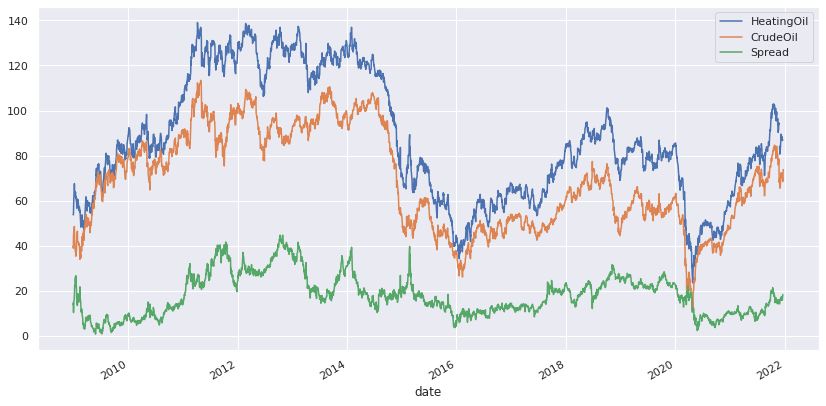

In [66]:
pricing_df.plot()

---

## Logreturns analysis

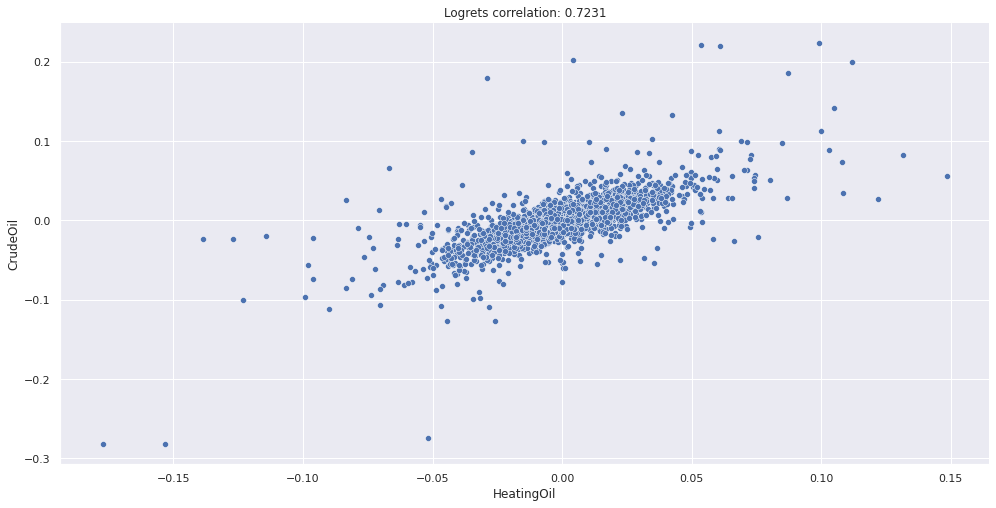

In [139]:
logrets_df = np.log(pricing_df).diff().dropna()
sns.relplot(data = logrets_df, x="HeatingOil", y="CrudeOil", height = 7, aspect=2)
corr = logrets_df.loc[:, ["HeatingOil", "CrudeOil"]].corr().iloc[1, 0]
_=plt.title(f"Logrets correlation: {corr:.4f}")

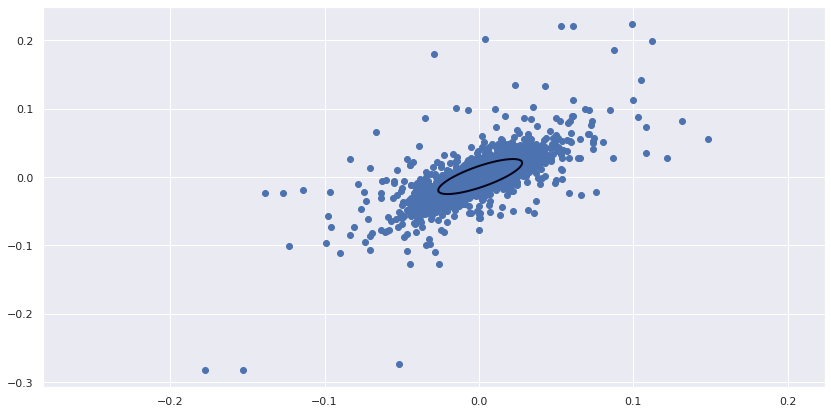

In [188]:
clf = EllipticEnvelope(contamination=0.25)
clf.fit(logrets_df.loc[:, ['CrudeOil', 'HeatingOil']].values)
xx1, yy1 = np.meshgrid(np.linspace(logrets_df.CrudeOil.min(), logrets_df.CrudeOil.max(), 500),
                       np.linspace(logrets_df.HeatingOil.min(), logrets_df.HeatingOil.max(), 500))
plt.figure(1)
Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
plt.contour(xx1, yy1, Z1, levels=[1], linewidths=2)
plt.scatter(x = logrets_df.HeatingOil, y = logrets_df.CrudeOil)

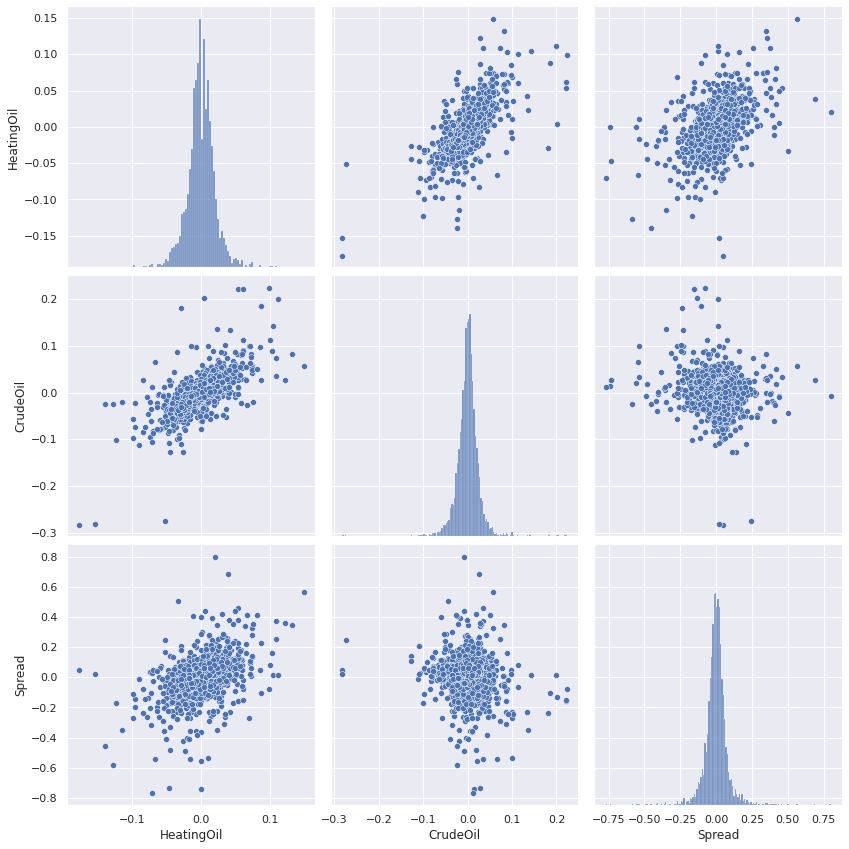

In [187]:
_ = sns.pairplot(logrets_df, height=4, aspect=1)

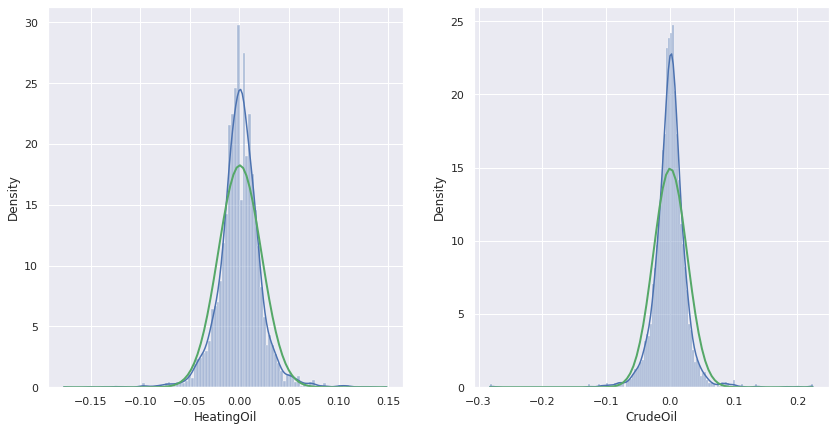

In [185]:
def plot_norm_fit(axes, data):
  xmin, xmax = data.min(), data.max()
  x = np.linspace(xmin, xmax, 100)
  fit = norm.fit(data)
  p = norm.pdf(x, *fit)
  axes.plot(x, p, 'g', linewidth=2)
  
fig, ax = plt.subplots(1, 2)
norm_fits = [norm.fit(data) for data in [logrets_df.HeatingOil, logrets_df.CrudeOil]]
sns.histplot(logrets_df.HeatingOil, alpha=0.4, kde=True, stat='density', ax = ax[0])
plot_norm_fit(ax[0], logrets_df.HeatingOil)

sns.histplot(logrets_df.CrudeOil, alpha=0.4, kde =True, stat='density', ax = ax[1])
plot_norm_fit(ax[1], logrets_df.CrudeOil)

---

## Copulas (theory)

### Formalna definicja


> Dwuwymiarową kopułą nazywamy funkcję:
> $C: [0, 1]^2 \rightarrow \mathbb{R}, $
> spełniającą warunki:
> * $C(u, 0) = C(0, v) = 0$ (grounded)
> * $C(u, 1) = u \wedge C(1, v)=v$ 
> * $2$-rosnąca


Kopuły pozwalają rozdzielić problem modelowania rozkładu łącznego zmiennych losowych na modelowanie osobno rozkładów brzegowych, a osobno ich struktury współzależności.

Oznaczmy przez $F_{XY}$ dystrybuantę rozkładu łącznego, $F_X(x)$, $F_Y(y)$ rozkłady brzegowe. Wtedy istnieje dwuwymiarowa kopuła $C$, taka że: 

$$F_{XY}(x, y) = C(F_X(x), F_Y(y)).$$ 

Jeżeli dodatkowo $XY$ ma rozkład ciągły, to $C$ jest określona jednoznacznie.

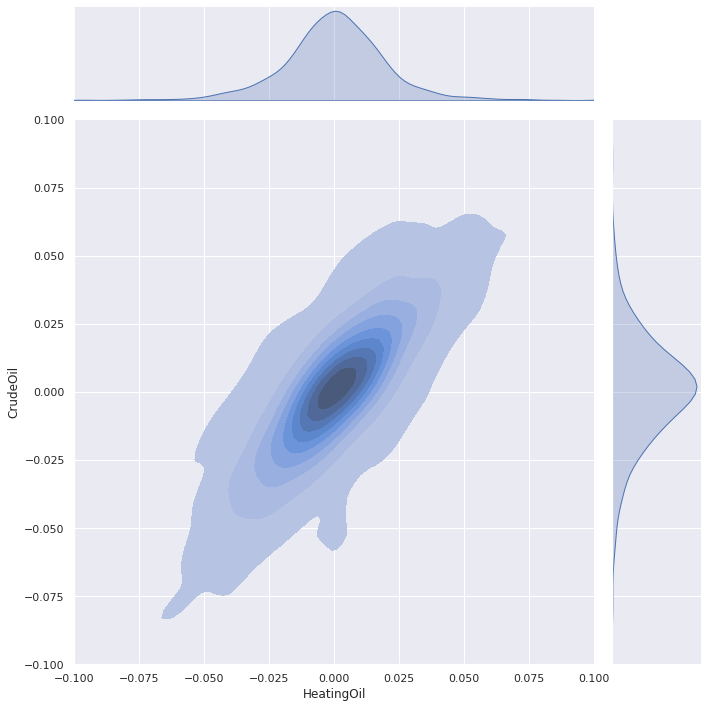

In [201]:
_=sns.jointplot(
    data=logrets_df,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1))